In [3]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import json

import skimage, skimage.io, skimage.transform, skimage.filters
import sklearn, sklearn.metrics

import importlib

import sys
sys.path.append('../src/')
import modutils
import word_processing as wp

import datetime, time, random
import tensorflow as tf

In [11]:
def build_cnn_graph(input_shape, cnn_arch, fc_arch, num_classes):
    tf.reset_default_graph()

    with tf.name_scope('Input'):
        tf_in_x = tf.placeholder(tf.float32, shape=(None, input_shape[0], input_shape[1], 1))
        tf_in_y = tf.placeholder(tf.int32, shape=(None,))

    tf_temp = tf_in_x
    for (i, (conv_filters, conv_size, conv_stride, pool_size, pool_stride)) in enumerate(cnn_arch):
        with tf.name_scope('Conv-MaxPool-{:02d}'.format(i)):
            tf_temp = tf.layers.conv2d(tf_temp, conv_filters, conv_size, conv_stride, activation=tf.nn.relu)
            tf_temp = tf.layers.max_pooling2d(tf_temp, pool_size, pool_stride)

    with tf.name_scope('FC'):
        tf_temp = tf.contrib.layers.flatten(tf_temp)
        for sz in fc_arch:
            tf_temp = tf.layers.dense(tf_temp, sz, activation=tf.nn.elu)
            
        tf_final = tf.layers.dense(tf_temp, num_classes)
        tf_prob = tf.nn.softmax(tf_final)
        tf_predicted = tf.cast(tf.argmax(tf_prob, axis=1), dtype=tf.int32)

    with tf.name_scope('LOSS'):
        tf_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_in_y, logits=tf_final))
        tf_train = tf.train.AdamOptimizer(1e-3).minimize(tf_loss)
        
        tf_accuracy, tf_upd_accuracy = tf.metrics.accuracy(labels=tf_in_y, predictions=tf_predicted)
        tf_update_metrics = tf.group(tf_upd_accuracy)
        
        tfsummary_logloss = tf.summary.scalar('Log-Loss', tf_loss)
        tfsummary_accuracy = tf.summary.scalar('1-Accuracy', 1-tf_accuracy)
        tfsummary = tf.summary.merge([tfsummary_logloss, tfsummary_accuracy])

    return {'in':{'data':tf_in_x, 'label':tf_in_y},
            'out':{'logit':tf_final, 'prob':tf_prob},
            'run':{'loss': tf_loss, 'upd_metrics':tf_update_metrics,'accuracy':tf_accuracy,
                   'train': tf_train, 'summary':tfsummary}}

def make_batches(sample, batch_size):
    raw_sample = [(i,z) for (i, x) in enumerate(sample) for z in x]
    random.shuffle(raw_sample)
    num_batches = len(raw_sample) // batch_size
    return [raw_sample[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]

def get_x_value(batch, xshape):
    tres = [wp.perform_transform(src_images[x[0]], transforms_all[x[1]]) for x in batch]
    res = [x[:, :xshape] if x.shape[1] >= xshape
            else np.hstack((x, np.zeros(shape=(x.shape[0], xshape-x.shape[1]))))
            for x in tres]
    return np.array(res)

def get_y_value(batch):
    return np.array([x[0] for x in batch])

In [67]:
src_shape = (32, 32)

graph_descr = build_cnn_graph(src_shape,
                              [(30, 5, 1, 3, 3), (200, 3, 1, 3, 3)],
                              [100], len(words))
model_name = 'D03_CHAR_CNN'
tf_model_file = '../data/tfmodels/d03_char_cnn/model-13.ckpt'

print('Graph created')

batch_size  = 256
set2dict = lambda x: {graph_descr['in']['data']: x[0],
                           graph_descr['in']['label']: x[1]}

set2dict_eval = lambda x: {graph_descr['in']['data']: x}

print('Preparation complete')

Graph created
Preparation complete


In [6]:
%%time
fname = '../data/ru_calibration.json'
extraction_path = os.path.join(os.path.dirname(fname),
                               os.path.basename(fname).split('.')[0])
with open(fname, 'r', encoding='utf-8') as f:
    src = json.load(f)
    
words = wp.extract_words_from_dataset(src, (1,))

transforms_rotation = wp.generate_rotations(-10, 10, 5)
transforms_scale = wp.generate_scales(0.75, 1.25, 5)
transforms_shift = wp.generate_shifts(-0.1, 0.1, 5)
transforms_cutoff = wp.generate_cutoffs(0.3, 0.5, 5)
combinations_all = wp.generate_combinations(transforms_rotation, transforms_shift,
                                       transforms_scale, transforms_cutoff)

fixed_post = [{'type':'trimx'},{'type':'trimy'}, {'type':'resize', 'y':32}]
transforms_all = wp.append_transformations(combinations_all, post_transforms=fixed_post)

test_sample = [np.random.choice(np.arange(len(transforms_all)), size=100) for i in range(len(words))]

src_images = [skimage.io.imread(os.path.join(extraction_path, x[1]), as_grey=True) for x in words]

Wall time: 635 ms


In [12]:
dt_now = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
tfsSaver = tf.train.Saver()

with tf.Session() as tfs:
    tfsSaver.restore(tfs, tf_model_file)
    t0 = time.perf_counter()
        
    test_res = []
    test_yf = []
    for (i, batch) in enumerate(make_batches(test_sample, batch_size)):
        print('Test batch {} of {}'.format(i * batch_size, len(test_sample)*len(test_sample[0])))
        valid_x = get_x_value(batch, src_shape[1]).reshape(-1, *src_shape, 1)
        valid_y = get_y_value(batch)
        test_yf.append(valid_y)
        test_res += modutils.runDataset(tfs, (valid_x, valid_y), batch_size, set2dict,
                                  [graph_descr['run']['loss'], graph_descr['out']['prob']])
        
    test_loss = np.sum([x[1] * x[2][0] for x in test_res]) / np.sum([x[1] for x in test_res])
    test_prob = np.concatenate([x[2][1] for x in test_res])
    test_pred = np.argmax(test_prob, axis=1)
    test_true = np.concatenate(test_yf)
    t1 = time.perf_counter()
        
print('Applied model in {:.2f} sec'.format(t1-t0))

INFO:tensorflow:Restoring parameters from ../data/tfmodels/d03_char_cnn/model-13.ckpt
Test batch 0 of 7600
Test batch 256 of 7600
Test batch 512 of 7600
Test batch 768 of 7600
Test batch 1024 of 7600
Test batch 1280 of 7600
Test batch 1536 of 7600
Test batch 1792 of 7600
Test batch 2048 of 7600
Test batch 2304 of 7600
Test batch 2560 of 7600
Test batch 2816 of 7600
Test batch 3072 of 7600
Test batch 3328 of 7600
Test batch 3584 of 7600
Test batch 3840 of 7600
Test batch 4096 of 7600
Test batch 4352 of 7600
Test batch 4608 of 7600
Test batch 4864 of 7600
Test batch 5120 of 7600
Test batch 5376 of 7600
Test batch 5632 of 7600
Test batch 5888 of 7600
Test batch 6144 of 7600
Test batch 6400 of 7600
Test batch 6656 of 7600
Test batch 6912 of 7600
Test batch 7168 of 7600


AttributeError: 'float' object has no attribute '2f'

In [23]:
sklearn.metrics.accuracy_score(test_true, test_pred)

0.99353448275862066

In [27]:
np.unique(test_true[test_true != test_pred], return_counts=True)

(array([ 9, 19, 20, 21, 22, 23, 26, 28, 31, 32, 36, 47, 52, 55, 56, 57, 58,
        60, 61, 67, 74]),
 array([1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 7, 6, 6, 3, 4, 2, 2, 1, 1], dtype=int64))

In [28]:
#53, 55, 56

In [43]:
sklearn.metrics.confusion_matrix(test_true, test_pred)[52:57, 52:57]

array([[90,  0,  0,  3,  0],
       [ 0, 99,  0,  0,  0],
       [ 0,  0, 99,  0,  0],
       [ 0,  0,  0, 94,  0],
       [ 5,  0,  0,  1, 92]])

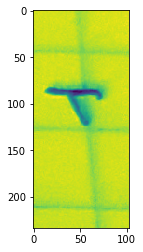

In [46]:
plt.imshow(src_images[52])

In [47]:
test_image = skimage.io.imread('../data/test01.jpg', as_grey=True)

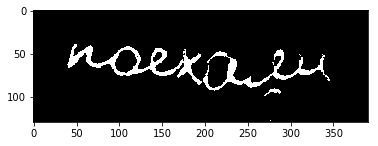

In [54]:
plt.imshow(test_image<0.4, cmap='gray')

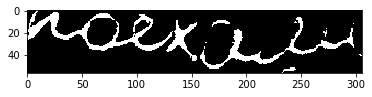

In [125]:
fin_image = wp.perform_transform(wp.trim_image_width(wp.trim_image_height(test_image<0.35)),
                                 [])
plt.imshow(fin_image, cmap='gray')

In [63]:
def extract_regions_xshift(src, xsize, xstride):
    sz = (src.shape[1] - xsize) // xstride
    offsets = [i * xstride for i in range(sz)]
    return np.array([src[:, off:(off+xsize)] for off in offsets])

In [65]:
tmp = extract_regions_xshift(fin_image, 32, 8)

In [126]:
dt_now = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
tfsSaver = tf.train.Saver()
xstride = 4
ystride = 4

res_ests = []
res_prob = []
res_pred = []

with tf.Session() as tfs:
    tfsSaver.restore(tfs, tf_model_file)
    t0 = time.perf_counter()
    
    num = (fin_image.shape[0] - src_shape[0]) // ystride
    test_res = []
    for i in range(num):
        print('Step {} of {}'.format(i, num))
        off = i * ystride
        xval = extract_regions_xshift(fin_image[off:(off+src_shape[0]),:], src_shape[1], xstride)
        tmp_res = modutils.runDataset(tfs, xval.reshape(-1, *src_shape, 1),
                                        batch_size, set2dict_eval,
                                  [graph_descr['out']['logit'], graph_descr['out']['prob']])
        
        res_ests.append(np.concatenate([x[2][0] for x in tmp_res]))
        res_prob.append(np.concatenate([x[2][1] for x in tmp_res]))
        res_pred.append(np.argmax(res_prob[-1], axis=1))
    t1 = time.perf_counter()
        
print('Applied model in {:.2f} sec'.format(t1-t0))

INFO:tensorflow:Restoring parameters from ../data/tfmodels/d03_char_cnn/model-13.ckpt
Step 0 of 6
Step 1 of 6
Step 2 of 6
Step 3 of 6
Step 4 of 6
Step 5 of 6
Applied model in 0.32 sec


In [127]:
pred_char = np.array(res_pred)

In [128]:
pred_conf = np.array([np.max(x, axis=1) for x in res_prob])

In [129]:
''.join([words[x][0] for (i,x) in enumerate(pred_char[0,:]) if pred_conf[0,i]>0.995])

'ф44фщШШШьХХ'

In [119]:
''.join([words[x][0] for x in pred_char[0,:]])

'УСССчпООШШШШлхфЛЛФт5тЯЕНННУУжжжЯЕКОШШШллй4ьььцшшХээттюттюлмвШШШШШШШШУУыы44АКОШШЧллййШ'

In [136]:
res_prob[0][:, 49]

array([  3.23734525e-07,   5.44628574e-06,   6.29884880e-07,
         1.36436449e-06,   3.79715183e-11,   4.39572385e-29,
         2.01260113e-37,   1.80320936e-37,   1.03701818e-29,
         2.45936286e-21,   6.19789918e-13,   2.17697164e-03,
         2.22816831e-04,   5.81868917e-08,   6.35134327e-08,
         2.39710896e-09,   5.27551094e-07,   7.94435644e-13,
         2.52991665e-14,   3.16207593e-09,   1.50871433e-15,
         2.09499996e-14,   4.16794828e-11,   2.58086704e-15,
         1.46733618e-14,   5.05879145e-17,   6.12002861e-15,
         6.67825657e-17,   2.61123663e-22,   1.06664960e-21,
         1.72252045e-22,   2.35078066e-21,   3.70683705e-20,
         5.45667394e-24,   5.97230124e-25,   4.80042507e-20,
         1.37335567e-18,   1.82787791e-17,   5.35543940e-16,
         1.09256264e-19,   2.63087737e-22,   1.24985850e-21,
         2.71098127e-18,   3.66053070e-16,   1.17666566e-17,
         4.13110087e-18,   4.49740522e-20,   7.75227953e-16,
         5.72528761e-11,